# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports and the Helper functions
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Train/Valid/Test Split

In [3]:
with open("./BHSig260/Bengali/Bengali_pairs.txt","r") as fp:
    lines = fp.readlines()
display(lines[:2])
display(lines[-2:])

['001/B-S-1-G-01.tif 001/B-S-1-F-01.tif 0\n',
 '001/B-S-1-G-02.tif 001/B-S-1-F-01.tif 0\n']

['009/B-S-9-G-24.tif 009/B-S-9-G-22.tif 1\n',
 '009/B-S-9-G-24.tif 009/B-S-9-G-23.tif 1\n']

In [4]:
train_lines = lines[0:2988]
val_lines = lines[2988:5976]
test_lines = lines[5976:]

with open("./BHSig260/Bengali/training.txt","w") as fp:
    fp.writelines(train_lines)
    
with open("./BHSig260/Bengali/val.txt","w") as fp:
    fp.writelines(val_lines)
    
with open("./BHSig260/Bengali/test.txt","w") as fp:
    fp.writelines(test_lines)
    
print(train_lines[-1])
print(val_lines[0])
print(val_lines[-1])
print(test_lines[0])

003/B-S-3-G-24.tif 003/B-S-3-G-23.tif 1

004/B-S-4-G-01.tif 004/B-S-4-F-01.tif 0

006/B-S-6-G-24.tif 006/B-S-6-G-23.tif 1

007/B-S-7-G-01.tif 007/B-S-7-F-01.tif 0



# Define the constants and Hyperparameter

In [5]:
training_pair_txt_filename = "./BHSig260/Bengali/training.txt" # 001 - 003
val_pair_txt_filename = "./BHSig260/Bengali/val.txt" #004 - 006
test_pair_txt_filename = "./BHSig260/Bengali/test.txt" #007 - 009
batch_size = 32
num_epochs = 21

## Define a Custom Dataset Class


In [6]:
class SiameseNetworkDataset(Dataset):
    #This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair
    def __init__(self,index_filename,transform=None,should_invert=True):
        self.index_filename = index_filename
        with open(index_filename,"r") as fp:
            self.lines = fp.readlines()
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        line = self.lines[index]
        first = "/".join(self.index_filename.split("/")[:-1])+"/"+line.split(" ")[0]
        second = "/".join(self.index_filename.split("/")[:-1])+"/"+line.split(" ")[1]
        flag = 0 if int(line.split(" ")[2][0])==1 else 1

        img0 = Image.open(first)
        img1 = Image.open(second)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([flag],dtype=np.float32))
    
    def __len__(self):
        return len(self.lines)

## Using the Custom Image Folder Dataset create Dataloaders

In [7]:
training_siamese_dataset = SiameseNetworkDataset(index_filename=training_pair_txt_filename,
                                                 transform=transforms.Compose(
                                                     [transforms.Resize((105,105)),transforms.ToTensor()]),
                                                 should_invert=False)

val_siamese_dataset = SiameseNetworkDataset(index_filename=val_pair_txt_filename,
                                                 transform=transforms.Compose(
                                                     [transforms.Resize((105,105)),transforms.ToTensor()]),
                                                 should_invert=False)


test_siamese_dataset = SiameseNetworkDataset(index_filename=test_pair_txt_filename,
                                                 transform=transforms.Compose(
                                                     [transforms.Resize((105,105)),transforms.ToTensor()]),
                                                 should_invert=False)

In [8]:
train_dataloader = DataLoader(training_siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

valid_dataloader = DataLoader(val_siamese_dataset,
                        num_workers=8,
                        batch_size=batch_size)

test_dataloader = DataLoader(test_siamese_dataset,
                             num_workers=8,
                             batch_size=1,
                             shuffle=True)

## Visualising some of the data pairs

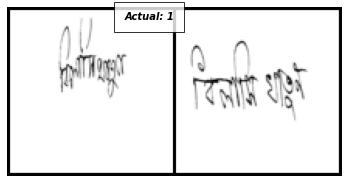

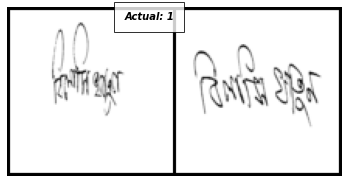

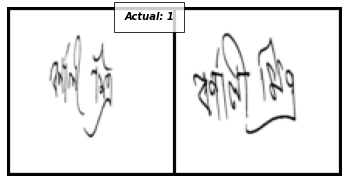

In [9]:
dataiter = iter(test_dataloader)
pred = list()
actual = list()
for i in range(3):
    example_batch = next(dataiter)
    img0 = example_batch[0]
    img1 = example_batch[1]
    label = int(example_batch[2][0])
    concatenated = torch.cat((img0,img1),0)
    imshow(torchvision.utils.make_grid(concatenated),'Actual: {}'.format(label))

## Define the Siamese Network
We will use a standard convolutional neural network

In [10]:
#create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

## Define the loss - Contrastive Loss

In [11]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(
                                          self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Train the model

In [ ]:
# Declare Siamese Network
model = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
#train the model

min_valid_loss = np.inf
for e in range(num_epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = model(img0,img1)
        loss = criterion(output1,output2,label)
        loss.backward()
        optimizer.step()
        train_loss = loss.item() * img0.size(0)
    
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 = img0.cuda(), img1.cuda()
        label = int(label[0][0])
        output1,output2 = model(img0,img1)
        loss = criterion(output1,output2,label)
        valid_loss = loss.item() * img0.size(0)

    train_loss = train_loss / len(train_dataloader)
    valid_loss = valid_loss / len(train_dataloader)
    print(f'Epoch {e+1} \nTraining Loss: {train_loss} \nValidation Loss: {valid_loss}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-small.pt')
    print("\n")

Epoch 1 
Training Loss: 0.21446118456252078 
Validation Loss: 0.38724414338456825
Validation Loss Decreased(inf--->0.387244) 	 Saving The Model


Epoch 2 
Training Loss: 0.09460288920301071 
Validation Loss: 0.03772539914922511
Validation Loss Decreased(0.387244--->0.037725) 	 Saving The Model


Epoch 3 
Training Loss: 0.02930602494706499 
Validation Loss: 0.126176636269752


Epoch 4 
Training Loss: 0.05224006860814196 
Validation Loss: 0.8610992431640625


Epoch 5 
Training Loss: 0.0946447621000574 
Validation Loss: 0.21668515814111589


Epoch 6 
Training Loss: 0.04772982952442575 
Validation Loss: 0.16164271374966235


Epoch 7 
Training Loss: 0.009648418489922869 
Validation Loss: 0.23596126982506285


Epoch 8 
Training Loss: 0.0005300650769408713 
Validation Loss: 0.019049672370261336
Validation Loss Decreased(0.037725--->0.019050) 	 Saving The Model


Epoch 9 
Training Loss: 0.00648517240869238 
Validation Loss: 0.06739787091600134


Epoch 10 
Training Loss: 0.0067038880066668735 


# Load the saved model & Lets find out accuracy for different threshold values for the similarity scores

In [13]:
saved_model = SiameseNetwork()
saved_model.load_state_dict(torch.load("model-small.pt"))
saved_model.cuda()

pred = list()
actual = list()

for i, data in enumerate(test_dataloader,0):
    img0, img1 , label = data
    img0, img1 = img0.cuda(), img1.cuda()
    label = int(label[0][0])
    output1,output2 = saved_model(img0,img1)
    euclidean_distance = F.pairwise_distance(output1, output2).item()
    pred.append(euclidean_distance)
    actual.append(label)

def calculate_accuracy_for_threshold(pred,actual,threshold):
    pred_label = [0 if x < threshold else 1 for x in pred]
    score = accuracy_score(actual,pred_label)
    print("Threshold : ",threshold," Accuracy : ",score)

calculate_accuracy_for_threshold(pred,actual,0.05)
calculate_accuracy_for_threshold(pred,actual,0.1)
calculate_accuracy_for_threshold(pred,actual,0.2)
calculate_accuracy_for_threshold(pred,actual,0.3)
calculate_accuracy_for_threshold(pred,actual,0.4)
calculate_accuracy_for_threshold(pred,actual,0.7)
calculate_accuracy_for_threshold(pred,actual,0.8)
calculate_accuracy_for_threshold(pred,actual,0.9)
calculate_accuracy_for_threshold(pred,actual,1.0)

Threshold :  0.05  Accuracy :  0.7312583668005355
Threshold :  0.1  Accuracy :  0.749665327978581
Threshold :  0.2  Accuracy :  0.8152610441767069
Threshold :  0.3  Accuracy :  0.8721552878179384
Threshold :  0.4  Accuracy :  0.9203480589022758
Threshold :  0.7  Accuracy :  0.9779116465863453
Threshold :  0.8  Accuracy :  0.9782463186077643
Threshold :  0.9  Accuracy :  0.9745649263721553
Threshold :  1.0  Accuracy :  0.9628514056224899


# Lets see some predictions

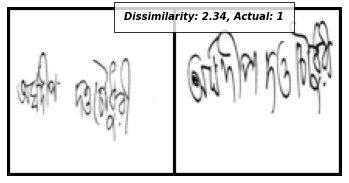

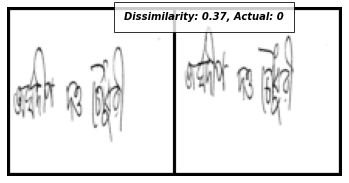

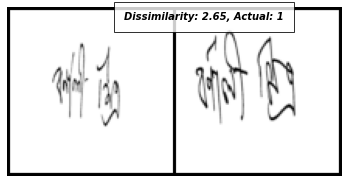

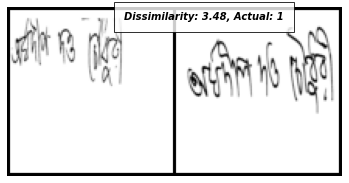

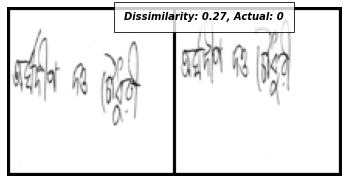

In [14]:
dataiter = iter(test_dataloader)
for i in range(5):
    example_batch = next(dataiter)
    img0 = example_batch[0]
    img1 = example_batch[1]
    label = int(example_batch[2][0])
    concatenated = torch.cat((img0,img1),0)
    output1,output2 = saved_model(Variable(img0).cuda(),Variable(img1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),
       'Dissimilarity: {:.2f}, Actual: {}'.format(euclidean_distance.item(),label))